In [ ]:
pip install pmdarima

In [ ]:
import pandas
import sklearn
import statsmodels

print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

1.3.5
1.0.2
0.13.2


In [ ]:
ls /content/drive/MyDrive/COLAB_data/ 

005930.KS.csv


## STEP 1 : 시계열 데이터 준비
---
- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있음
- 우린 종가(Close)만 사용

-> 데이터 불러올 때, 시계열로 불러오고(index_col, Parse_dates 사용)  종가만 불러오기

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

#구글 코랩 데이터 불러오기
from google.colab import drive
drive.mount("/content/drive")
data_path = '/content/drive/MyDrive/COLAB_data/005930.KS.csv'

# Time Series 생성
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv(data_path, index_col='Date', parse_dates=True) #시계열로 불러야하니까 index 및 parse_dates 추가해줌
ts = df['Close']

ts.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Date
2021-05-04    82600.0
2021-05-06    82300.0
2021-05-07    81900.0
2021-05-10    83200.0
2021-05-11    81200.0
Name: Close, dtype: float64

## STEP 2 : 각종 전처리 수행
---
- 결측치 처리
- 로그 변환

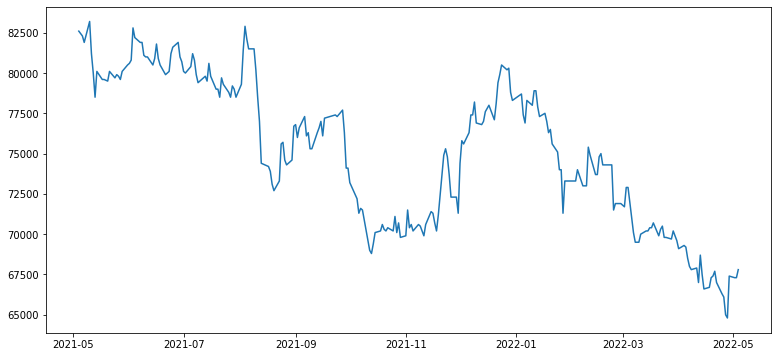

In [ ]:
#시각화로 안정성 여부 확인
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6 

plt.plot(ts)

origin data의 그래프를 보았을 때 많은 전처리를 해줘야할 것 같은 느낌이 듦.....  

우선, rolling statistics를 통해 평균, 표준편차를 그래프로 시각화 해보고 p-value 값을 확인해보자.

Series([], Name: Close, dtype: float64)


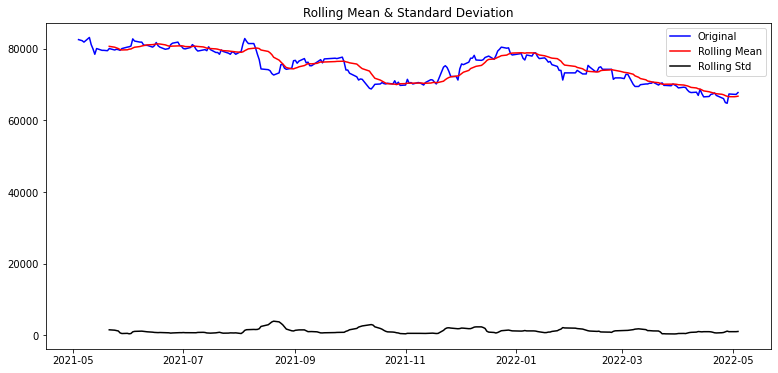

In [ ]:
#결측치 유무 확인
ts[ts.isna()]
#결측치 보간해줌
ts=ts.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인
print(ts[ts.isna()])

#rolling statistics를 통해 그래프 시각화
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
plot_rolling_statistics(ts, window=12)



In [ ]:
#Stationary 통계적 확인
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.596445
p-value                          0.485379
#Lags Used                       0.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


p-value를 확인해 본 결과 0.48로 생각보다 큰 값을 가지고 있음 -> 시계열이 안정적이지 않은 것으로 보임 -> 안정화 해줘야함


---


### 1) 로그함수 변환하기
- 시간 추이에 따라 분산이 증감하는 것은 확실치 않으나 우선 돌려보기로함

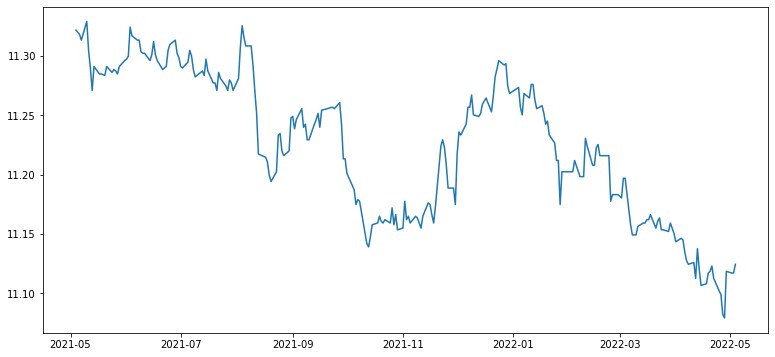

In [ ]:
ts_log = np.log(ts)
plt.plot(ts_log)

In [ ]:
#로그함수 변환의 효과가 어땠는지 확인하기 위해 다시 ADF test진행
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.547210
p-value                          0.510041
#Lags Used                       0.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


기존 **p-value값 0.48에서 0.51로 증가**함.

-> 로그함수변화는 오히려 안정성을 더 높임  
-> origin data가 시간에 따른 평균이 낮아지고 있으니......ㅠㅠ moving average를 제거해보자

---

### 2) 추세(trend) 상쇄하기  
- 시간에 따른 평균값 변화 제거하기

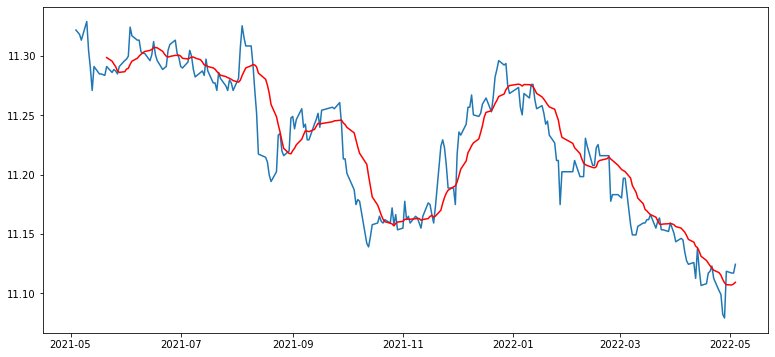

In [ ]:
moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

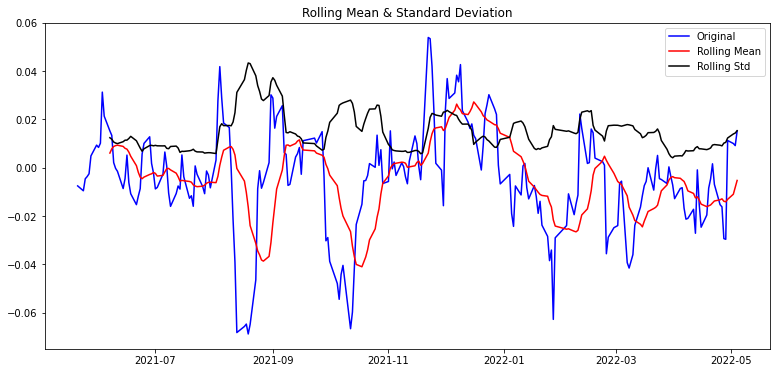

Results of Dickey-Fuller Test:
Test Statistic                  -4.904808
p-value                          0.000034
#Lags Used                       1.000000
Number of Observations Used    234.000000
Critical Value (1%)             -3.458608
Critical Value (5%)             -2.873972
Critical Value (10%)            -2.573396
dtype: float64


In [ ]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.dropna(inplace=True) #window 값에 따른 결측치 제거
ts_log_moving_avg.head(15) # 값 확인

 #그래프 확인
plot_rolling_statistics(ts_log_moving_avg)
#ADF test 확인
augmented_dickey_fuller_test(ts_log_moving_avg)

p-value값 0.00034로 확실히 감소한 것이 확인되어 안정적인 데이터라고 할 수 있음.

그래프를 봤을땐 안정적이다... 라고 할 수 있을만큼 이쁜 그래프는 아니었는데 p-value 값이 0.0003까지 떨어지다니 신기하네...  

생각해보니 y축의 크기가 상기 그래프들의 축보다 확연히 작아진것을 생각하지 못했다! 이런 기본적인걸...

## STEP 3 : 시계열 안정성 분석

---

- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

앞에서 그래프 분석 및 ADF test를 진행했으니 시계열 분해, Residual 안정성 확인을 이어서 해보자.

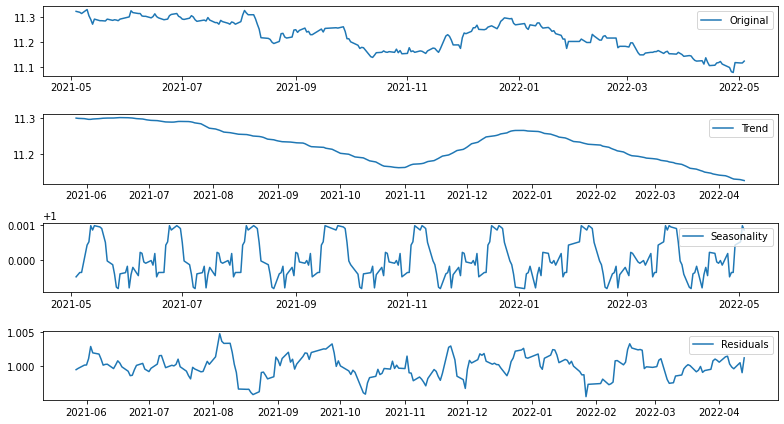

In [ ]:
# 시계열 분해
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)

# decomposition = seasonal_decompose(ts_log, freq=12) 
#freq 설정해주지 않으면 오류남 -> 월별 데이터니까 12로 선택

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()



multiplication 참고 자료 : https://dodonam.tistory.com/89

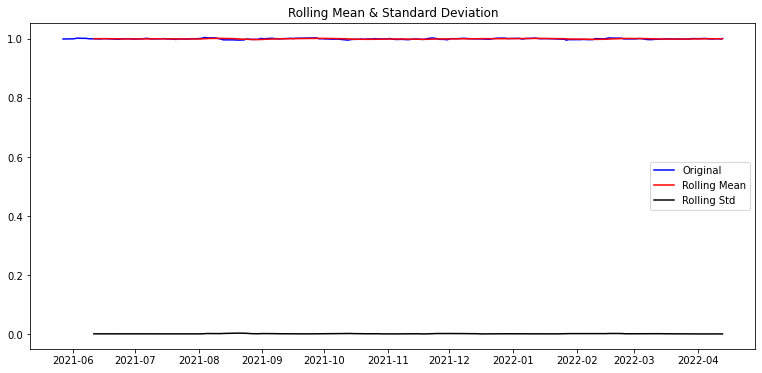

Results of Dickey-Fuller Test:
Test Statistic                  -5.458259
p-value                          0.000003
#Lags Used                       1.000000
Number of Observations Used    215.000000
Critical Value (1%)             -3.461136
Critical Value (5%)             -2.875079
Critical Value (10%)            -2.573986
dtype: float64


In [ ]:
#Residual 그래프확인
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

#Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

이 Residual 그래프는 처음엔 당황했으나, 생각해보니 한 그래프상에 origin, mean, std값이 한번에 나와야하니 모양이 이렇게 된게 아닐까 싶다.  

Residual로 처리한 데이터는 std값이 거의 0에 가까울만큼 값들이 정리되었으니까.  

우선 이전 시계열 분석에서 만든 그래프를 통해 각각의 값이 잘 나오는 것을 확인했으며, RDF test를 통해 p-velue값이 압도적으로 작아진 것을 보았으니 그래프는 우선 확인용으로 넘기도록하자.

### STEP 4 : 학습, 테스트 데이터셋 생성

---

- 학습, 테스트 데이터셋 분리

In [ ]:
print(ts)

Date
2021-05-04    82600.0
2021-05-06    82300.0
2021-05-07    81900.0
2021-05-10    83200.0
2021-05-11    81200.0
               ...   
2022-04-28    64800.0
2022-04-29    67400.0
2022-05-02    67300.0
2022-05-03    67300.0
2022-05-04    67800.0
Name: Close, Length: 247, dtype: float64


처음 학습, 테스트 데이터셋 분리를 생각했을 때 이전 버전을 생각하고 타입을 바꿔줘야하나? 생각했는데, 생각해보니 이번 것은 sklearn을 사용하여 학습하는 것이 아니니까 데이터 타입은 교체하지 않아도 될 것 같다.

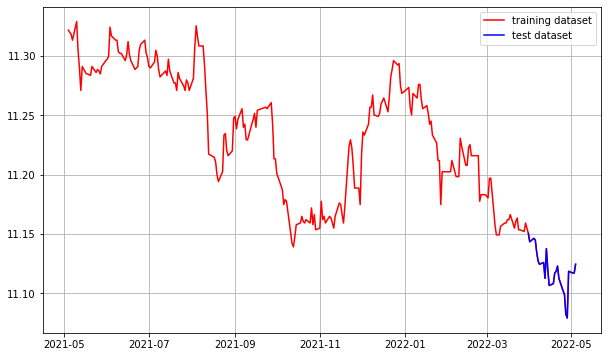

In [ ]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):] 
# : 의 위치를 통해 9/1의 비율로 쉽게 나눌 수 있다!
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()


### STEP 5 : 적정 ARIMA 모수 찾기

---

- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

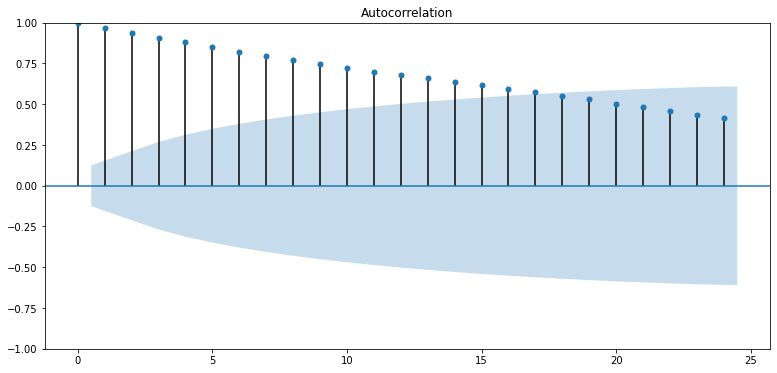

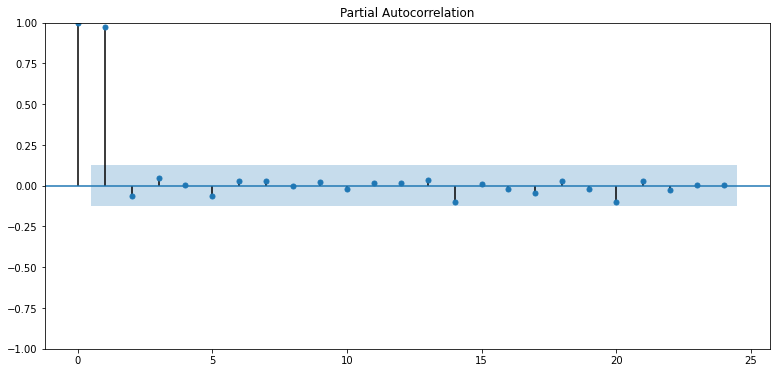

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

상기 ACF, PACF 그래프를 보았을 때,   
-  ACF 도표가 자기상관이 크고 양수이며, 천천히 감소하는 패턴을 보여주는 것으로 보임  
(유의미한 자기상관이 있는 것이며, 정상적이라면 0에 근접한 자기상관을 보여줌)
- PACF 도표에서는 p=1이 적합해보임.  
 p가 2 이상인 구간에서 PACF가 0에 가까워지는 것을 보아 고려하지 않아도 될 것 같음  

 따라서, ACF를 통한 q = 0, PACF를 통한 p = 1을 선택함

Results of Dickey-Fuller Test:
Test Statistic                -1.486548e+01
p-value                        1.694057e-27
#Lags Used                     0.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64


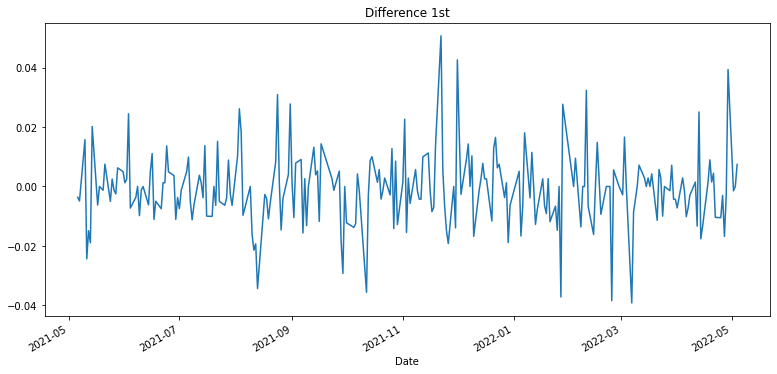

In [ ]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

d 값을 구하기 위해 1차 차분을 진행했을 때, p-value가 1.694057e-27로 매우 작은 값을 가지고 있어 데이터가 잘 처리되었음을 알 수 있음.  
하지만 혹시 모르니 2차 차분으로 한번 더 진행해보기로함.


Results of Dickey-Fuller Test:
Test Statistic                -7.463991e+00
p-value                        5.263125e-11
#Lags Used                     1.300000e+01
Number of Observations Used    2.310000e+02
Critical Value (1%)           -3.458980e+00
Critical Value (5%)           -2.874135e+00
Critical Value (10%)          -2.573482e+00
dtype: float64


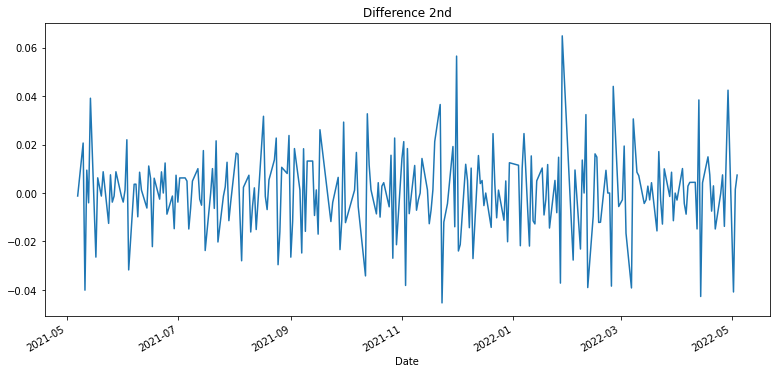

In [ ]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

2차 차분으로 돌려보았을 때,   
1.694057e-27 에서 5.263125e-11로 오히려 값이 증가한 것을 알 수 있음   
따라서 d 값은 1로 지정.

### STEP 6 : ARIMA 모델 훈련과 테스트

---


- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore') 

# Build Model
model = ARIMA(train_data, order=(1, 1, 0)) # p=1, d=1, q=0 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  222
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 656.947
Date:                Thu, 05 May 2022   AIC                          -1309.895
Time:                        12:41:11   BIC                          -1303.099
Sample:                             0   HQIC                         -1307.151
                                - 222                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0680      0.065      1.042      0.298      -0.060       0.196
sigma2         0.0002   9.98e-06     15.343      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.00   Jarque-

coef값은 0에서 가장 떨어졌을때 가장 이상적이며 p값은 0과 가장 가까울때가 가장 좋음

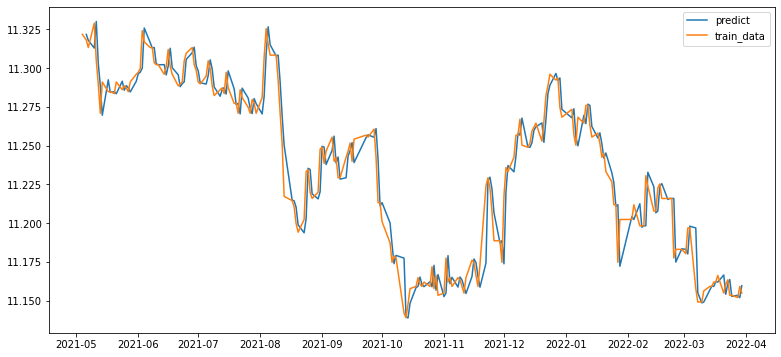

In [ ]:
#시각화 진행
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

부분적으로 살짝 회향하는 값들이 있긴 하지만 흐름이 유사한 것을 보아 이정도라면 내 돈을 넣는다고 가정했을 때,,,, 괜찮다고 생각된다.

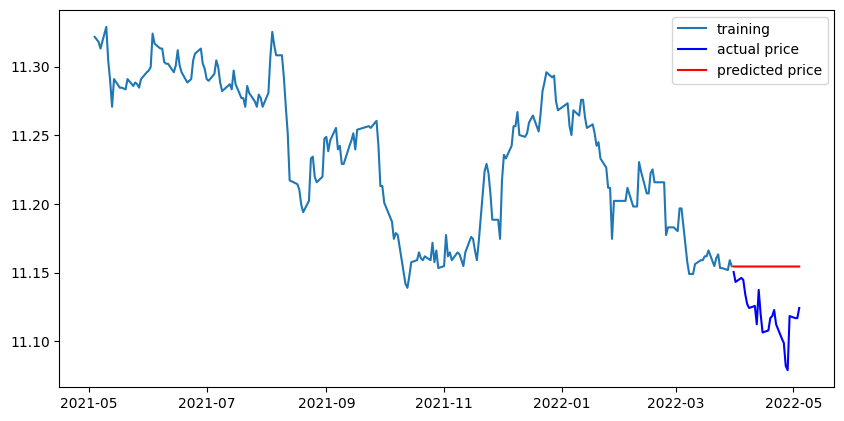

In [ ]:
#forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% 
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

이게... 맞나...? 실제값과 prediction값이 전혀 맞지 않는다... 삼성이 문제인가 내 코드가 문제인가...  

어디 학습이 잘됐는지 확인하기위해 전에 사용한 sklearn의 mse, rmse와 회귀모형의 성능을 확인하는 MAPE값을 확인해보자  

- MAPE란 Mean of Absolute Percentage Error의 약자로 이름 그대로 예측 오차의 절대값을 씌워 퍼센트로 나타낸 것이라고 보면 되고, 0에 가까울 수록 좋다

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))


MSE:  7101742.082844112
MAE:  2386.225146319989
RMSE:  2664.90939486582
MAPE: 3.57%


MAPE가 3%대로 예측 오차는 작다고 볼 수 있을 것 같다.  
또한 RMSE가 전 평가 기준이었던 3,000 이하로 내려갔으니 이 또한 좋은 값을 나타내고 있어 학습은 잘되었다고 볼 수 있을 것 같다.  



## 다른 주식 종목 예측해보기

---



### 1. STARBUCKS (우리들의 영원한 별다방)

---

In [ ]:
ls '/content/drive/MyDrive/COLAB_data/'

005930.KS.csv  122870.KQ.csv  SBUX.csv


### 1. 시계열 데이터 준비

In [ ]:

#구글 코랩 데이터 불러오기
from google.colab import drive
drive.mount("/content/drive")
data_path = '/content/drive/MyDrive/COLAB_data/SBUX.csv'

# Time Series 생성
import warnings
warnings.filterwarnings('ignore')

df_SB = pd.read_csv(data_path, index_col='Date', parse_dates=True) 
ts_SB = df_SB['Close']

ts_SB.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Date
2021-05-05    113.480003
2021-05-06    114.739998
2021-05-07    114.339996
2021-05-10    114.300003
2021-05-11    113.550003
Name: Close, dtype: float64

### 2. 전처리 수행

---

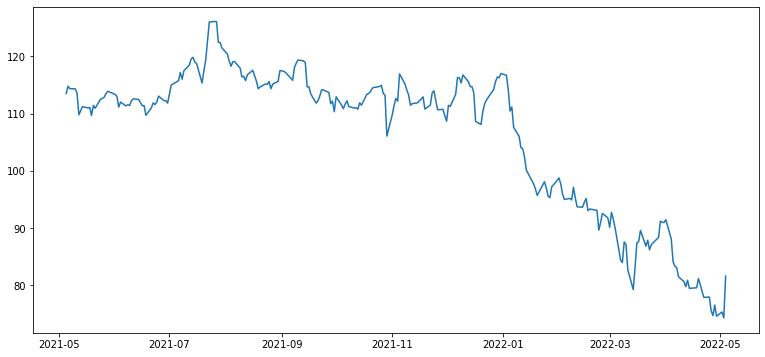

In [ ]:
#시각화로 안정성 여부 확인
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6 

plt.plot(ts_SB)

우주최강 스벅은 21년이 마지막인가...  

슬프지만 과제를 해야하니 Origin 그래프의 p-value 값을 구하고 그래프를 그려보자

Series([], Name: Close, dtype: float64)


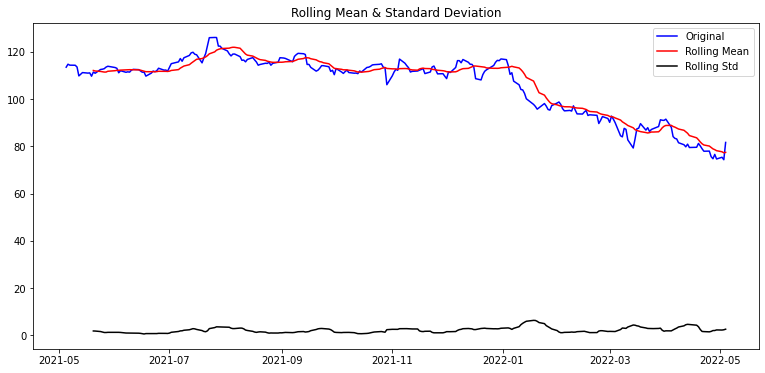

In [ ]:
ts_SB[ts_SB.isna()]
#결측치 보간
ts_SB=ts_SB.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인
print(ts_SB[ts_SB.isna()])

#rolling statistics를 통해 그래프 시각화
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
plot_rolling_statistics(ts_SB, window=12)

In [ ]:
#Stationary 통계적 확인
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

augmented_dickey_fuller_test(ts_SB)

Results of Dickey-Fuller Test:
Test Statistic                  -0.261606
p-value                          0.930769
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


세상에 p-value가 0.9로 굉장히 불안정한 값이다...   
어서 전처리를 진행하자!

### 1) 로그함수 변환
- 시간에 따른 분산의 증감이 없어 큰 효과는 없을 것 같으나 우선 차례대로 돌려보자



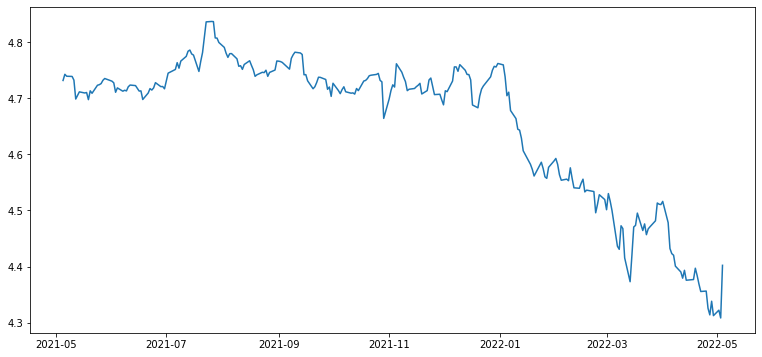

In [ ]:
ts_log = np.log(ts_SB)
plt.plot(ts_log)

In [ ]:
#로그함수 변환의 효과가 어땠는지 확인하기 위해 다시 ADF test진행
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.228969
p-value                          0.934979
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


역시나 **p-value 값이 오히려 증가**했다.  
추세 상쇄로 고고

---

### 2)추세 상쇄하기



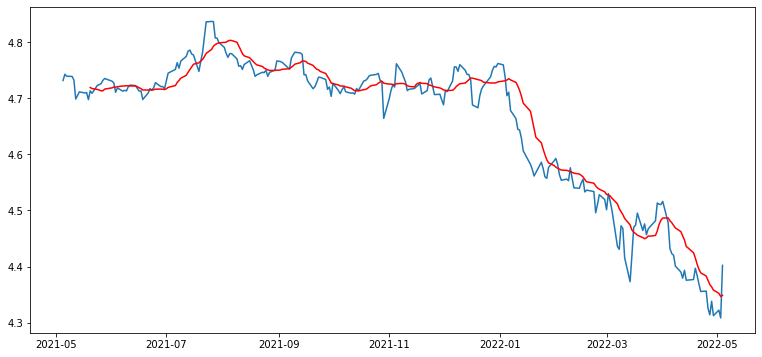

In [ ]:
moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

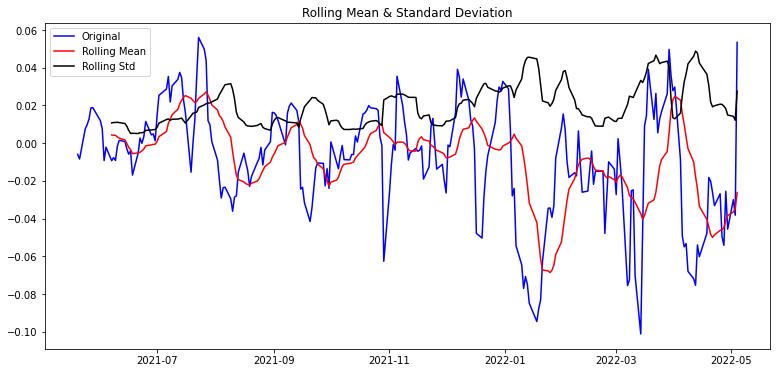

Results of Dickey-Fuller Test:
Test Statistic                  -5.071815
p-value                          0.000016
#Lags Used                       4.000000
Number of Observations Used    237.000000
Critical Value (1%)             -3.458247
Critical Value (5%)             -2.873814
Critical Value (10%)            -2.573311
dtype: float64


In [ ]:
ts_log_moving_avg = ts_log - moving_avg 
ts_log_moving_avg.dropna(inplace=True) #window 값에 따른 결측치 제거
ts_log_moving_avg.head(15) # 값 확인시 결측치 없음

#그래프 확인
plot_rolling_statistics(ts_log_moving_avg)
#ADF test 확인
augmented_dickey_fuller_test(ts_log_moving_avg)

p-value가 0.000016까지 확 떨어져 안정적인 데이터라고 할 수 있으니, 이후 과정을 진행하자

### 3. 시계열 안정성 분석

---

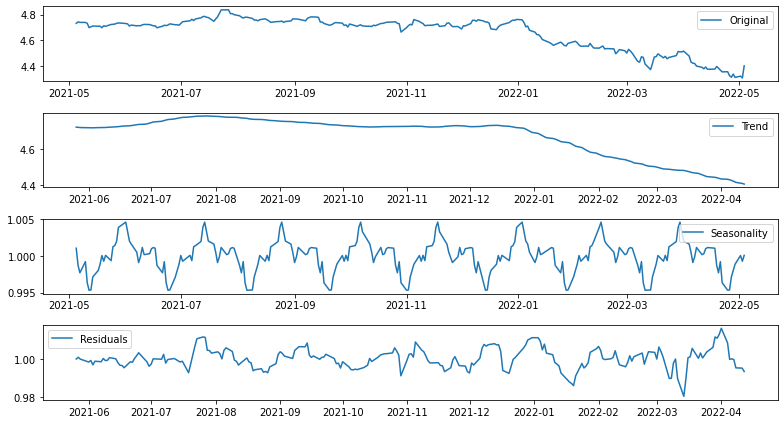

In [ ]:
# 시계열 분해
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

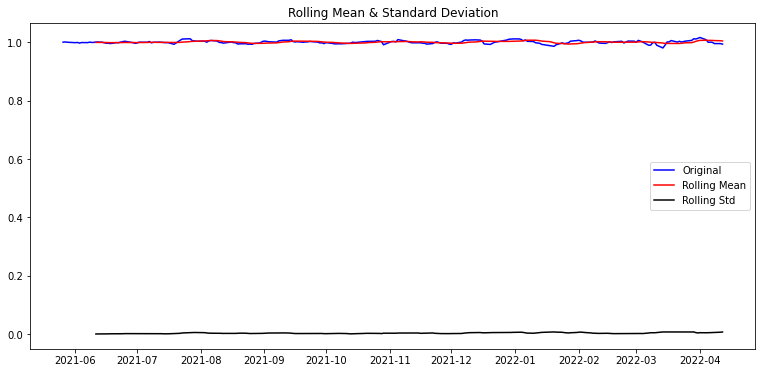

Results of Dickey-Fuller Test:
Test Statistic                  -5.453533
p-value                          0.000003
#Lags Used                       4.000000
Number of Observations Used    218.000000
Critical Value (1%)             -3.460708
Critical Value (5%)             -2.874891
Critical Value (10%)            -2.573886
dtype: float64


In [ ]:
#Residual 그래프확인
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

#Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

### 4. 학습, 테스트 데이터셋 설정

---

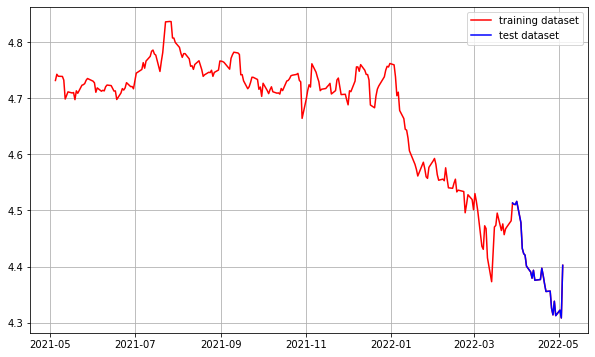

In [ ]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):] 

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### 5. 적정 ARIMA 모수 찾기

---

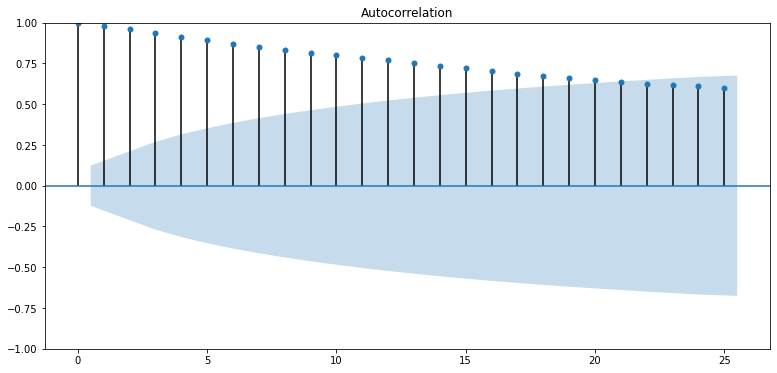

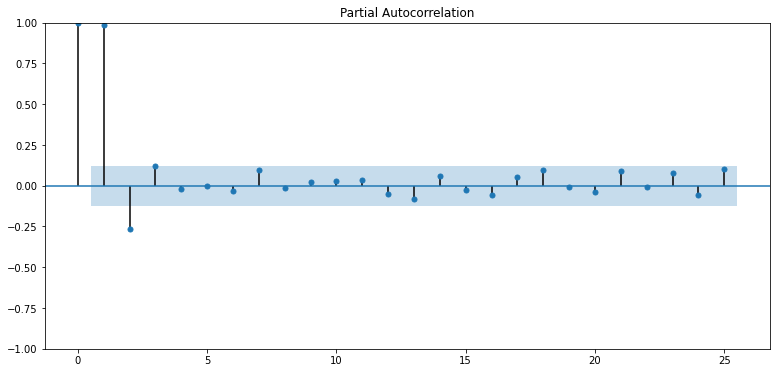

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

상기 그래프를 통해 PACF도표의 p = 1 이 적합함을 확인함

따라서 p = 1, q = 0을 선택. d를 구하기 위한 차분 진행!

Results of Dickey-Fuller Test:
Test Statistic                -1.405737e+01
p-value                        3.100073e-26
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64


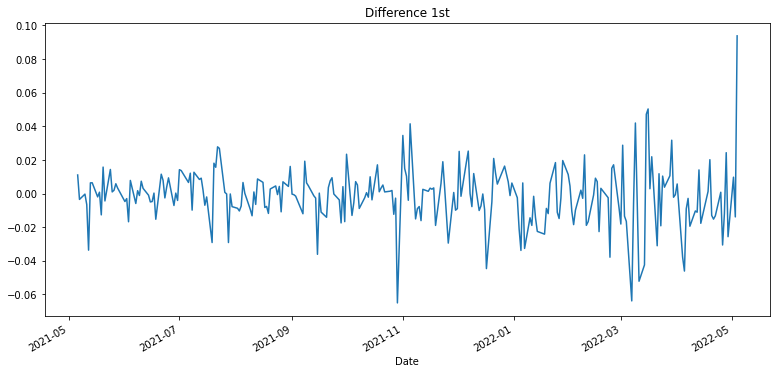

In [ ]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -8.527222e+00
p-value                        1.061137e-13
#Lags Used                     1.000000e+01
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


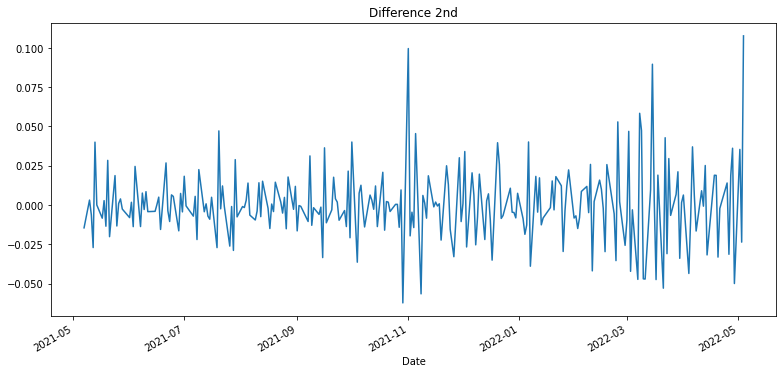

In [ ]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

2차 차분까지 구해본 결과,  
1차분의 p-value 값이 3.100073e-26로 굉장히 낮아 d = 1로 결정함

### 6. ARIMA 모델 훈련과 테스트

---

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore') 

# Build Model
model = ARIMA(train_data, order=(1, 1, 0)) # p=1, d=1, q=0 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 612.804
Date:                Thu, 05 May 2022   AIC                          -1221.607
Time:                        13:59:15   BIC                          -1214.766
Sample:                             0   HQIC                         -1218.847
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0697      0.049      1.433      0.152      -0.026       0.165
sigma2         0.0003    1.6e-05     16.111      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.00   Jarque-

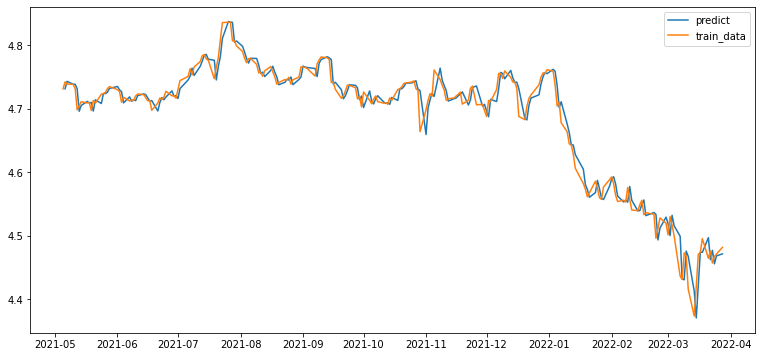

In [ ]:
#시각화 진행
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

호오... 눈으로 간단히 보니, 앞서 진행한 삼성보다 튀는 값이 적어 맘에든다.

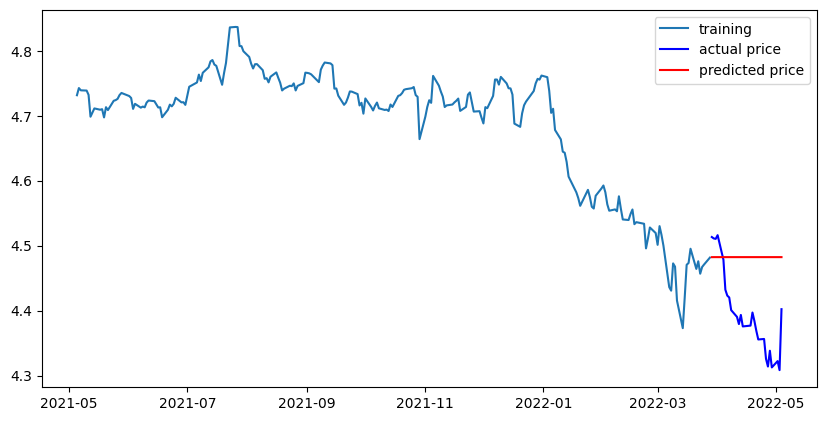

In [ ]:
#forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% 
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()